In [1]:
from jax import jit, vmap, random
import jax.numpy as np
import numpy as onp
import jax

# enable float 64
from jax.config import config
config.update('jax_enable_x64', True)

In [2]:
from utils_response import create_df_response
import pandas as pd
import datetime


In [3]:
# https://github.com/google/jax/issues/10144
def binomial_transition(xi, τ, dt=1):
    kb    = np.maximum(1.0 - np.exp(-τ*dt), 0)
    pop   = onp.random.binomial(onp.int64(xi), kb )
    return jax.device_put(pop)

def checkpopvars(x, pop):
    return np.clip(x, 0, pop)

def f(t, x, β, γ, N, dt=1):
    """
    Process model
    """
    S = x.at[0, :].get()
    I = x.at[1, :].get()
    R = x.at[2, :].get()
    C = x.at[3, :].get()


    s2i = binomial_transition(S, β * I / N, dt)
    i2r = binomial_transition(I, γ, dt)

    S  = S - s2i
    I  = I + s2i - i2r
    R  = R + i2r
    C  = s2i

    return np.array([S, I, R, C])

def g(t, x, θ, ρ=0.3):
    """
    Observational model.
        Args:
            t: time
            x: state space
            θ: parameters
            ρ: report rate
    """
    y = onp.random.binomial(onp.int64(x.at[3, :].get()), ρ)
    return jax.device_put(y)

def f0(pop=1e6, inf_init=1/100, m=300):
    """
    Initial guess of the state space.
    """
    I0 = pop * inf_init
    S0 = pop - I0
    R0 = 0
    C0 = 0

    x0 = np.ones((4, m)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)

    return x0

In [4]:
N = 8e6

γ_truth = 1/4         # days
β_truth = 2 * γ_truth # days

T     = 70
dt    = 1
ens   = 500
x0    = f0(N, 1/10, m=ens)
x_sim = x0

x_sim = np.full((4, T, ens), np.nan)
x_sim = x_sim.at[:, 0, :].set(x0)

for t in range(1, T):
    x     = f(t, x_sim.at[:, t-1, :].get(), β_truth, γ_truth, N)
    x_sim = x_sim.at[:, t, :].set(x)

C =  x_sim.at[3, :, :].get()

k = jax.random.PRNGKey(1)

obs_use   = C.at[:, onp.random.randint(ens)].get()
obs_use_n = np.maximum(obs_use + np.squeeze(jax.random.normal(k, shape=(T, 1))*0.5), 0)


In [5]:
observation_df          = pd.DataFrame(obs_use_n, columns=['y1'])
observation_df["oev1"]  = 1 +( 0.2 * observation_df["y1"])**2
observation_df["date"] = pd.date_range(start=datetime.datetime(2020, 1, 1), periods=T, freq='D')
observation_df

,y1,oev1,date
0,0.000000,1.000000e+00,2020-01-01
1,43721.273525,7.646199e+07,2020-01-02
2,51001.528501,1.040462e+08,2020-01-03
3,56397.555398,1.272274e+08,2020-01-04
4,61214.474932,1.498885e+08,2020-01-05
...,...,...,...
65,1.896511,1.143870e+00,2020-03-06
66,2.546555,1.259398e+00,2020-03-07
67,1.363627,1.074379e+00,2020-03-08
68,1.168051,1.054574e+00,2020-03-09


In [6]:
from ifeakf import ifeakf

model_settings ={
    "m"           : 300,                           # number of ensembles
    "p"           : 2,                             # number of parameters
    "k"           : 1,                             # number of observations
    "n"           : 4,                             # number of state variables / dimension of the state space
    "dt"          : 1,                             # time step
    "param_name"  : ["β", "γ"],                    # name of the parameters
    "dates"       : observation_df["date"].values, # integration dates (for the process model) | date_{t+1}-date_t = dt
    "param_truth" : [β_truth, γ_truth]             # true parameter values (not required - just for the example)
    }

if_settings = {
   "Nif"                : 50,                           # number of iterations of the IF
   "type_cooling"       : "geometric",                  # type of cooling schedule
   "shrinkage_factor"   : 0.9,                          # shrinkage factor for the cooling schedule
   "inflation"          : 1.01,                         # inflation factor for spreading the variance after the EAKF step
   "assimilation_dates" : observation_df["date"].values # assimilation dates (for the inference)
}

# Function to be used for the ikeafk function.
f_if  = lambda t, state, params: f(t, state, params.at[0, :].get(), params.at[1, :].get(), N)
g_if  = lambda t, state, params: g(t, state, params)
f0_if = lambda params: f0(pop=N, inf_init=1/100, m=model_settings["m"])

γmin = 1/15
γmax = 1/3

βmin = 0.5 * γmin
βmax = 3   * γmax


state_space_range = np.array([[0, N], [0, N], [0, N], [0, N]])
parameters_range = np.array([[βmin, βmax], [γmin, γmax]])

σ_perturb   = np.array([(βmax-βmin) / 2, (γmax-γmin) / 2] )


In [23]:
obs_df          = observation_df.set_index("date").resample("W-Sun").sum()
obs_df["oev1"]  = 1 +(0.5*obs_df["y1"].values)**2

obs_df.index.values[-1] = model_settings["dates"][-1]

if_settings["assimilation_dates"] = obs_df.index.values


In [24]:

from eakf import check_param_space, check_state_space, eakf, checkbound_params, inflate_ensembles
from ifeakf import random_walk_perturbation, cooling, geometric_cooling
from utils_probability import sample_uniform, truncated_normal
from tqdm import tqdm


In [25]:
cooling_sequence   = cooling(if_settings["Nif"], type_cool=if_settings["type_cooling"], cooling_factor=if_settings["shrinkage_factor"])

k           = model_settings["k"] # Number of observations
p           = model_settings["p"] # Number of parameters (to be estimated)
n           = model_settings["n"] # Number of state variable
m           = model_settings["m"] # Number of stochastic trajectories / particles / ensembles

sim_dates   = model_settings["dates"]
assim_dates = if_settings["assimilation_dates"]

param_range = parameters_range.copy()
std_param   = param_range[:, 1] - param_range[:,0]
SIG         = std_param ** 2 / 4; #  Initial covariance of parameters


In [27]:
perturbation = σ_perturb

assimilation_times = len(assim_dates)

θpost_all = np.full((p, m, assimilation_times, if_settings["Nif"]), np.nan)
θmean     = np.full((p,    if_settings["Nif"]+1), np.nan)

keys_if   = jax.random.split(key, if_settings["Nif"])

In [28]:

def sample_uniform2(xrange, m):
    p       = xrange.shape[0]
    samples = np.full((p, m), np.nan)

    for ip in range(p):
        samples = samples.at[ip, :].set(onp.random.uniform(xrange[ip, 0], xrange[ip, 1], m))
    return samples

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    from scipy.stats import truncnorm
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_truncated_normal(mean, sd, xrange, m):
    p       = xrange.shape[0]
    samples = np.full((p, m), np.nan)
    for ip in range(p):
        samples = samples.at[ip, :].set(get_truncated_normal(mean=mean[ip], sd=sd[ip], low=xrange[ip, 0], upp=xrange[ip, 1]).rvs(m))
    return samples


for n in tqdm(range(if_settings["Nif"])):
    if n==0:
        #θprior = sample_uniform(keys_if[n], param_range[:,0], param_range[:,1], p, m)
        θprior = sample_uniform2(param_range, m)
        x      = f0_if(θprior)
        θmean  = θmean.at[:, n].set(np.mean(θprior, -1))

    else:
        pmean     = θmean.at[:,n].get()
        pvar      = SIG * cooling_sequence[n]
        θprior    = sample_truncated_normal(pmean, pvar ** (0.5), param_range, m)
        x         = f0_if(θprior)

    t_assim = 0
    ycum    = np.zeros((k, m))
    θtime   = np.full((p, m, assimilation_times), np.nan)

    for t, date in enumerate(sim_dates):
        x   = f_if(t, x, θprior)
        y   = g_if(t, x, θprior)

        ycum += y

        if date == assim_dates[t_assim]:

            σp      = perturbation*cooling_sequence.at[n].get()
            θprior  = random_walk_perturbation(θprior, σp, p, m)
            θprior  = checkbound_params(θprior, param_range)

            # Measured observations
            z     = obs_df.loc[date][[f"y{i+1}" for i in range(k)]].values
            oev   = obs_df.loc[date][[f"oev{i+1}" for i in range(k)]].values

            x_prior = x.copy()

            # Update state space
            x_post, _ = eakf(x_prior, ycum, z, oev)
            θpost, _  = eakf(θprior,  ycum, z, oev)

            x_post = inflate_ensembles(x_post, inflation_value=if_settings["inflation"], m=m)
            θpost  = inflate_ensembles(θpost, inflation_value=if_settings["inflation"], m=m)

            # check for a-physicalities in the state and parameter space.
            x_post = check_state_space(x_post, state_space_range)
            θpost  = checkbound_params(θpost, param_range)

            θprior = θpost.copy()
            x      = x_post.copy()
            # Update parameter space
            #θ   = checkbound_params(keys_if[n], θ, param_range)
            # save posterior parameter
            θtime    = θtime.at[:, :, t_assim].set(θpost)
            ycum     = np.zeros((k, m))
            t_assim += 1

    θpost_all = θpost_all.at[:, :, :, n].set(θtime)
    θmean     = θmean.at[:, n+1].set(θtime.mean(-1).mean(-1)) # average posterior over all assimilation times and them over all ensemble members


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


In [21]:
θmle = θmean.copy()
θpost_all.shape

(2, 300, 11, 50)

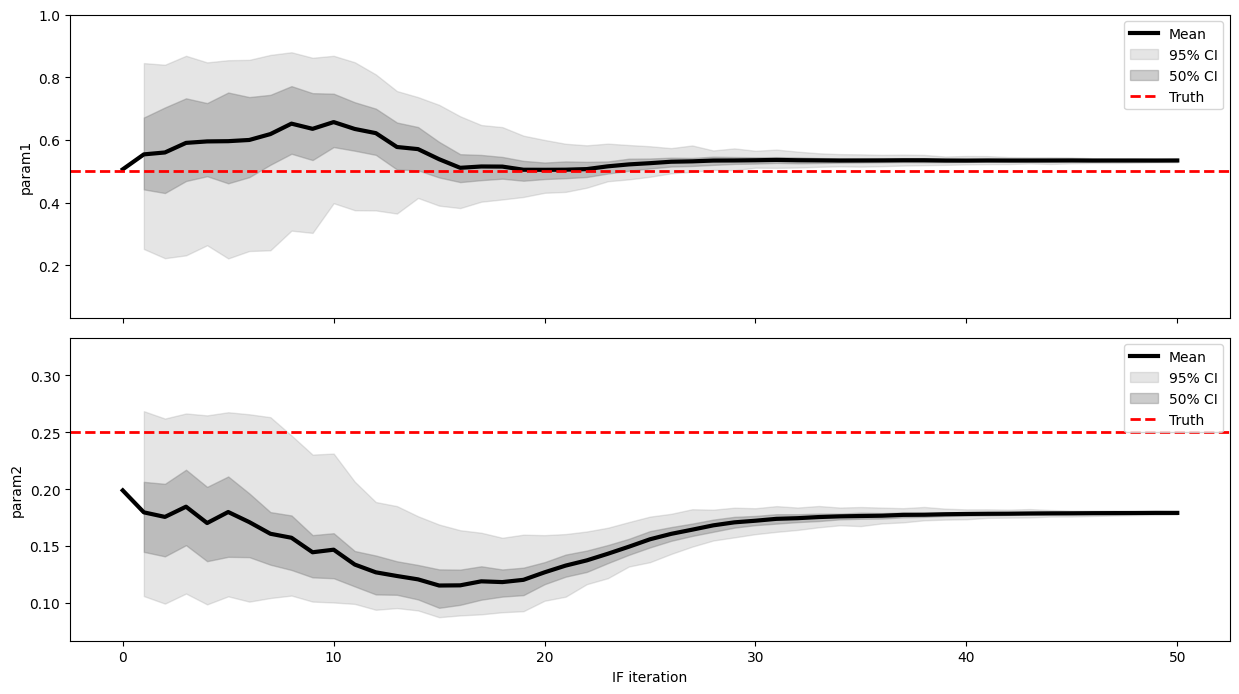

In [22]:
from diagnostic_plot import convergence_plot
import matplotlib.pyplot as plt

p_truth = model_settings["param_truth"]

fig, ax = plt.subplots(2, 1, figsize=(12.5, 7.2), sharex=True)
convergence_plot(θmle, θpost_all.mean(-2), parameters_range, param_truth=p_truth, ax=ax, fig=fig)
